In [315]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
from geopy.distance import geodesic

In [316]:
def parse_trackpoint(line):
    # Extract components from the line
    time_utc = line[1:7]  # HHMMSS
    latitude_raw = line[7:15]  # DDMMmmmN
    longitude_raw = line[15:24]  # DDDMMmmmE
    gps_altitude = int(line[25:30])  # GGGG
    pressure_altitude = int(line[30:35])  # LLLL

    # Convert UTC time
    hours = int(time_utc[:2])
    minutes = int(time_utc[2:4])
    seconds = int(time_utc[4:6])

    # Convert latitude to decimal degrees
    latitude_deg = int(latitude_raw[:2])
    latitude_min = float(latitude_raw[2:7]) / 1000
    latitude = latitude_deg + latitude_min / 60
    if latitude_raw[7] == 'S':
        latitude *= -1

    # Convert longitude to decimal degrees
    longitude_deg = int(longitude_raw[:3])
    longitude_min = float(longitude_raw[3:8]) / 1000
    longitude = longitude_deg + longitude_min / 60
    if longitude_raw[8] == 'W':
        longitude *= -1

    return {
        "time": f"{hours:02}:{minutes:02}:{seconds:02}",
        "latitude": latitude,
        "longitude": longitude,
        "gps_altitude": gps_altitude,
        "pressure_altitude": pressure_altitude,
    }

In [317]:
file_name = "2024-05-19 10_05_00.igc"
# file_name = "2018-07-16 09_13_56.igc"

with open(file_name, 'r') as file:
    lines = file.readlines()

flight_data = [line for line in lines if line.startswith('B')]
flight_date = lines[1].split(":")[1]
records = [parse_trackpoint(line) for line in flight_data]

df = pd.DataFrame(records)
# Her 5 sn'de bir veri al
df = df[df.index % 5 == 0]
df["time"] = pd.to_datetime(flight_date + df["time"])
df.head()

/var/folders/ss/5qhyykzn7ws047pz5bmmgw1r0000gn/T/ipykernel_30224/3590058154.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["time"] = pd.to_datetime(flight_date + df["time"])


,time,latitude,longitude,gps_altitude,pressure_altitude
0,2024-05-19 10:05:00,40.031200,32.328300,1090,1144
5,2024-05-19 10:05:05,40.031200,32.328300,1089,1144
10,2024-05-19 10:05:10,40.031183,32.328283,1089,1144
15,2024-05-19 10:05:15,40.031200,32.328300,1090,1144
20,2024-05-19 10:05:20,40.031250,32.328017,1083,1136


In [318]:
prev_coord = None
def calculate_distance(df):
    global prev_coord
    if prev_coord is None:
        prev_coord = (df["latitude"], df["longitude"])
        return 0
    coord1 = (df["latitude"], df["longitude"])
    coord2 = prev_coord
    return geodesic(coord1, coord2).meters

prev_total_distance = 0
def caluculate_total_distance(row):
    global prev_total_distance
    prev_total_distance += row["distance"]
    return prev_total_distance

df["distance"] = df.apply(calculate_distance, axis=1)
df["total_distance"] = df.apply(caluculate_total_distance, axis=1)
df["climb"] = df["pressure_altitude"].diff()
df["climb_rate"] = df["climb"] / 5
df.head(50)

,time,latitude,longitude,gps_altitude,pressure_altitude,distance,total_distance,climb,climb_rate
0,2024-05-19 10:05:00,40.031200,32.328300,1090,1144,0.000000,0.000000,NaN,NaN
5,2024-05-19 10:05:05,40.031200,32.328300,1089,1144,0.000000,0.000000,0.0,0.0
10,2024-05-19 10:05:10,40.031183,32.328283,1089,1144,2.334184,2.334184,0.0,0.0
15,2024-05-19 10:05:15,40.031200,32.328300,1090,1144,0.000000,2.334184,0.0,0.0
20,2024-05-19 10:05:20,40.031250,32.328017,1083,1136,24.812964,27.147148,-8.0,-1.6
25,2024-05-19 10:05:25,40.031500,32.327817,1078,1129,53.024089,80.171237,-7.0,-1.4
30,2024-05-19 10:05:30,40.031600,32.327517,1076,1129,80.268503,160.439739,0.0,0.0
35,2024-05-19 10:05:35,40.031750,32.327117,1078,1130,118.029965,278.469704,1.0,0.2
40,2024-05-19 10:05:40,40.031817,32.326683,1080,1131,154.044144,432.513848,1.0,0.2
45,2024-05-19 10:05:45,40.032033,32.326283,1079,1131,195.425011,627.938859,0.0,0.0


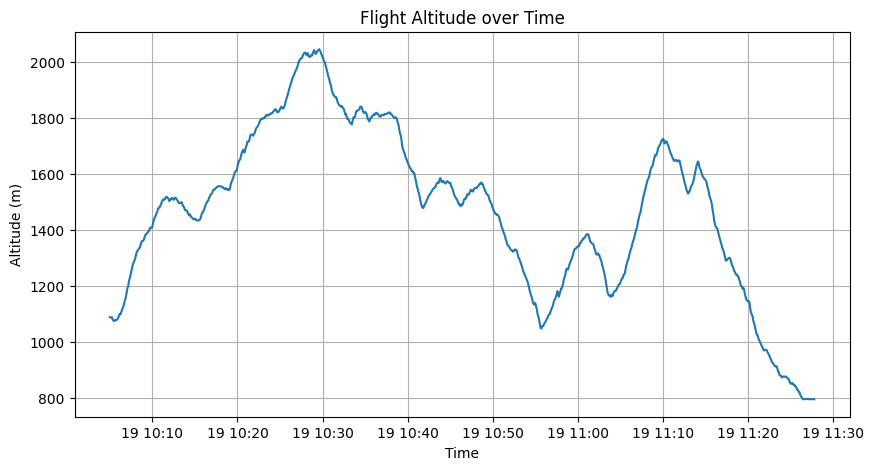

In [319]:
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['gps_altitude'])
plt.xlabel('Time')
plt.ylabel('Altitude (m)')
plt.title('Flight Altitude over Time')
plt.grid(True)
plt.show()


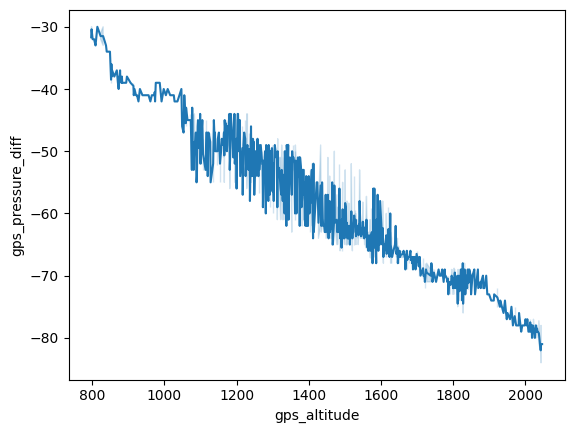

In [320]:
df["gps_pressure_diff"] = df["gps_altitude"] - df["pressure_altitude"]
graph = sns.lineplot(x="gps_altitude", y="gps_pressure_diff", data=df)

In [321]:
coordinates = list(zip(df["latitude"], df["longitude"]))
map = fm.Map(location=coordinates[0], zoom_start=13)
for coord in coordinates:
    fm.CircleMarker(location=coord, radius=1, color='blue', fill=True, fill_color='blue', popup="Point").add_to(map)
map.save("map.html")